In [2]:
%load_ext autoreload
%autoreload 

In [101]:

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time

os.chdir('/home/ali/packages/s2p-lbm/')
from scipy import stats
import suite2p
from suite3d import plot_utils as plot

In [4]:
from pathlib import Path

In [26]:
# raw_data_path_server = '\\zortex.cortexlab.net\Subjects\SS003\2024-08-06\subset_tifs'

# save_path =  Path('/mnt/md0/runs/s2p-SS003_2024-08-06_1-2-3-4-server/')

# ops = suite2p.default_ops()
# ops['look_one_level_down'] = True
# ops['subfolders'] = []
# ops['nplanes'] = 7
# ops['fs'] = 4.12
# ops['batch_size'] = 400
# ops['threshold_scaling'] = 0.1
# ops['tau'] = 1.3
# ops['nonrigid'] = False
# ops['ignore_flyback'] = [0,1,2,3,4]
# ops['data_path'] = [raw_data_path]
# ops['save_path0'] = str(save_path)
# # print(ops)
# ops['do_registration'] = 2

In [27]:
# %%time
# output_ops = suite2p.run_s2p(ops=ops)

In [29]:
raw_data_path = '/mnt/md0/runs/s2p-SS003_2024-08-06_1-2-3-4/raw'

save_path =  Path('/mnt/md0/runs/s2p-SS003_2024-08-06_1-2-3-4/')

ops = suite2p.default_ops()
ops['look_one_level_down'] = True
ops['subfolders'] = []
ops['nplanes'] = 7
ops['fs'] = 4.12
ops['batch_size'] = 400
ops['threshold_scaling'] = 0.1
ops['tau'] = 1.3
ops['nonrigid'] = False
ops['ignore_flyback'] = []
ops['data_path'] = [raw_data_path]
ops['save_path0'] = str(save_path)
# print(ops)
ops['do_registration'] = 2

In [30]:
# %%time
# output_ops = suite2p.run_s2p(ops=ops)

In [36]:
all_ops = []
all_stats = []
Fs = []
spks = []
iscell = []
for plane in n.arange(ops['nplanes']):
    planedir = (save_path / 'suite2p' / f'plane{plane}')
    statx = planedir / 'stat.npy'
    opx = planedir / 'ops.npy'
    Fsx = planedir / 'F.npy'
    spksx = planedir / 'spks.npy'
    iscellx = planedir / 'iscell.npy'
    
    all_stats.append(n.load(statx, allow_pickle=True))
    all_ops.append(n.load(opx, allow_pickle=True).item())
    Fs.append(n.load(Fsx))
    spks.append(n.load(spksx))
    iscell.append(n.load(iscellx))

iscell = n.concatenate(iscell).astype(bool)

mean_img = n.stack([op['meanImg'] for op in all_ops])

ref_img = n.stack([op['refImg'] for op in all_ops])


# corr_map = n.stack([op['Vcorr'] for op in all_ops])

nz = mean_img.shape[0]

In [60]:
Fs = n.concatenate(Fs)[iscell[:,0]]
spks = n.concatenate(spks)[iscell[:,0]]

In [57]:
imgdir = Path('/mnt/md0/runs/pub-figs/')

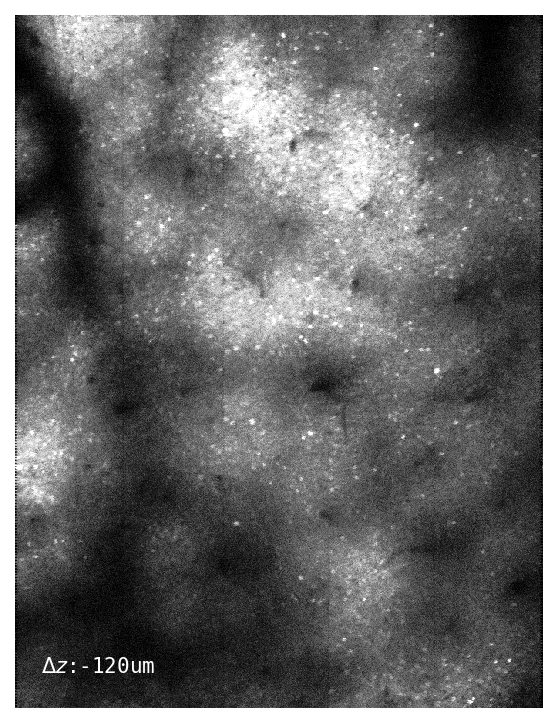

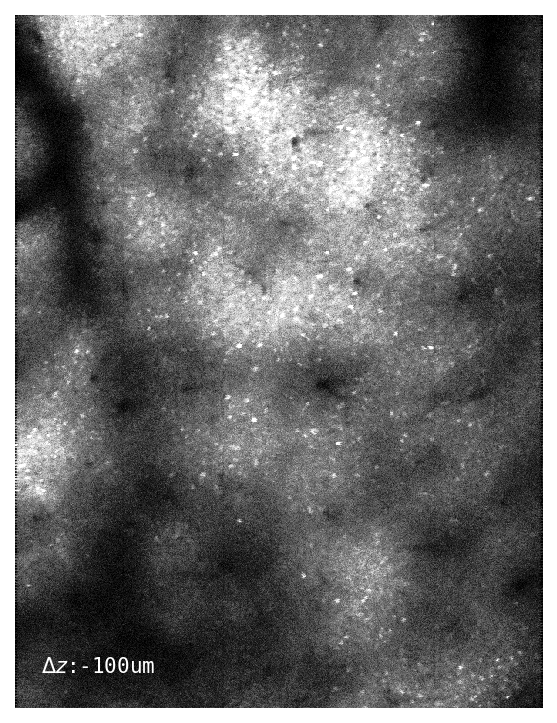

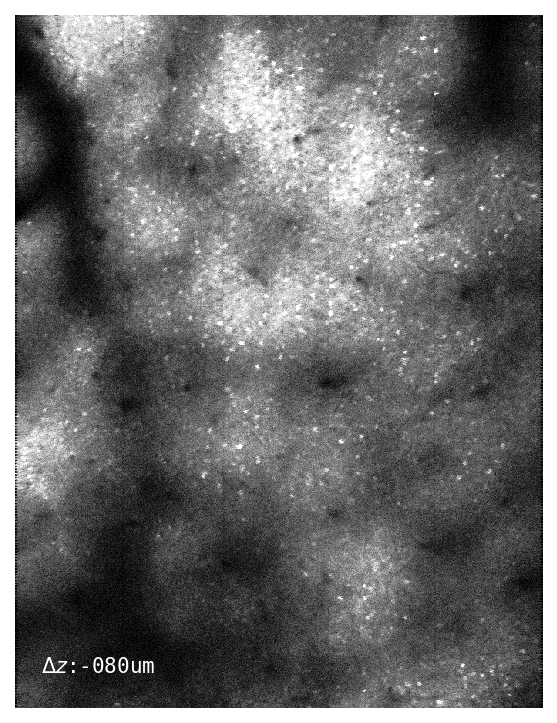

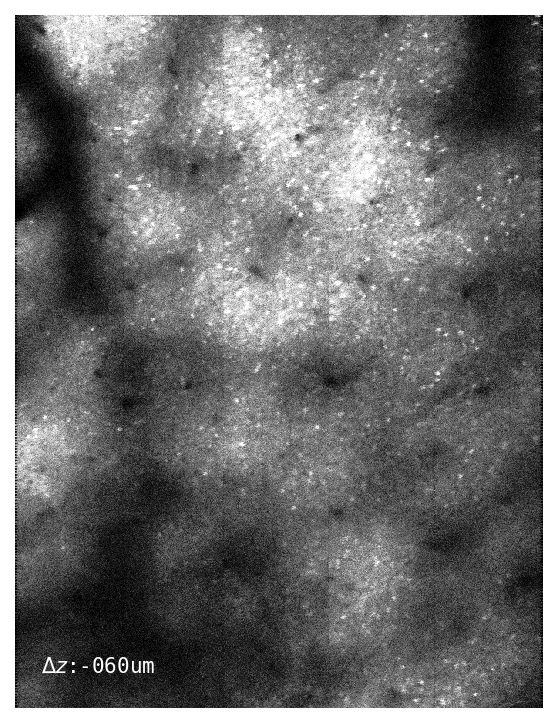

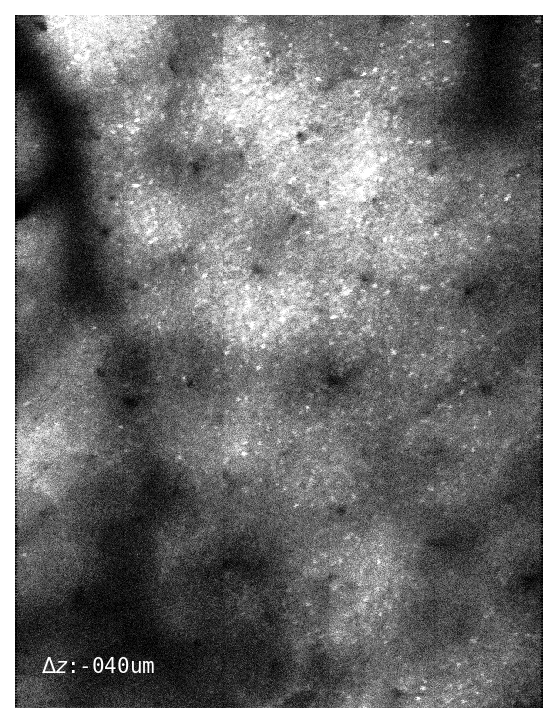

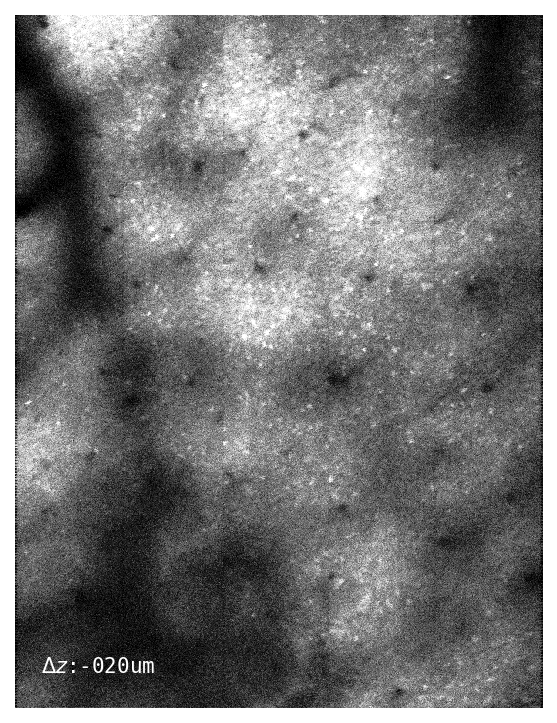

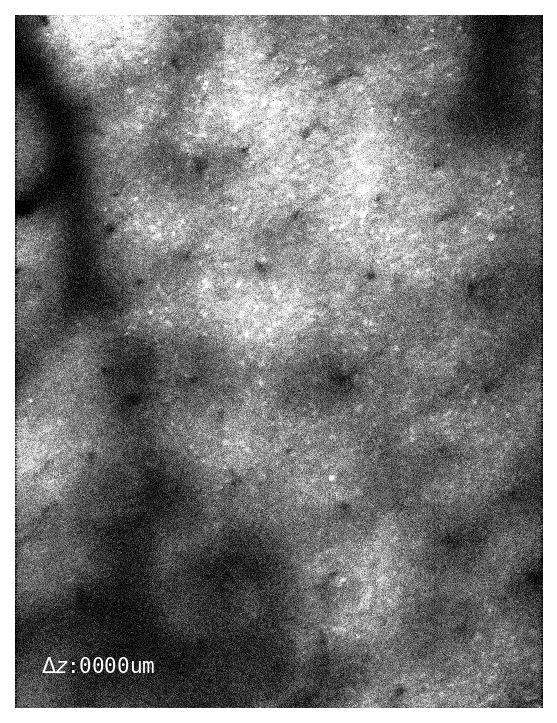

In [64]:
gifdir = imgdir / 'lbm-largefov-s2p-refimg-gif'
os.makedirs(gifdir, exist_ok=True)
for i in range(nz):
    f,ax,__ = plot.show_img(ref_img[i])
    depth = (-nz+i + 1)*20
    ax.text(0.05, 0.05, f'$\Delta z$:{depth:04d}um', transform = ax.transAxes, fontdict={'color':'white', 'family':'monospace'})
    plt.savefig(gifdir / f'lbm-largefov-ss003-20240806-s2p-refimg-plane{i+1:02d}.png', bbox_inches = 'tight')

In [79]:
from importlib import reload

In [80]:
reload(plot)

<module 'suite3d.plot_utils' from '/home/ali/packages/s2p-lbm/suite3d/plot_utils.py'>

In [88]:
cmap = plt.get_cmap('winter', lut=nz)

Text(0.5, 0, 'Frames')

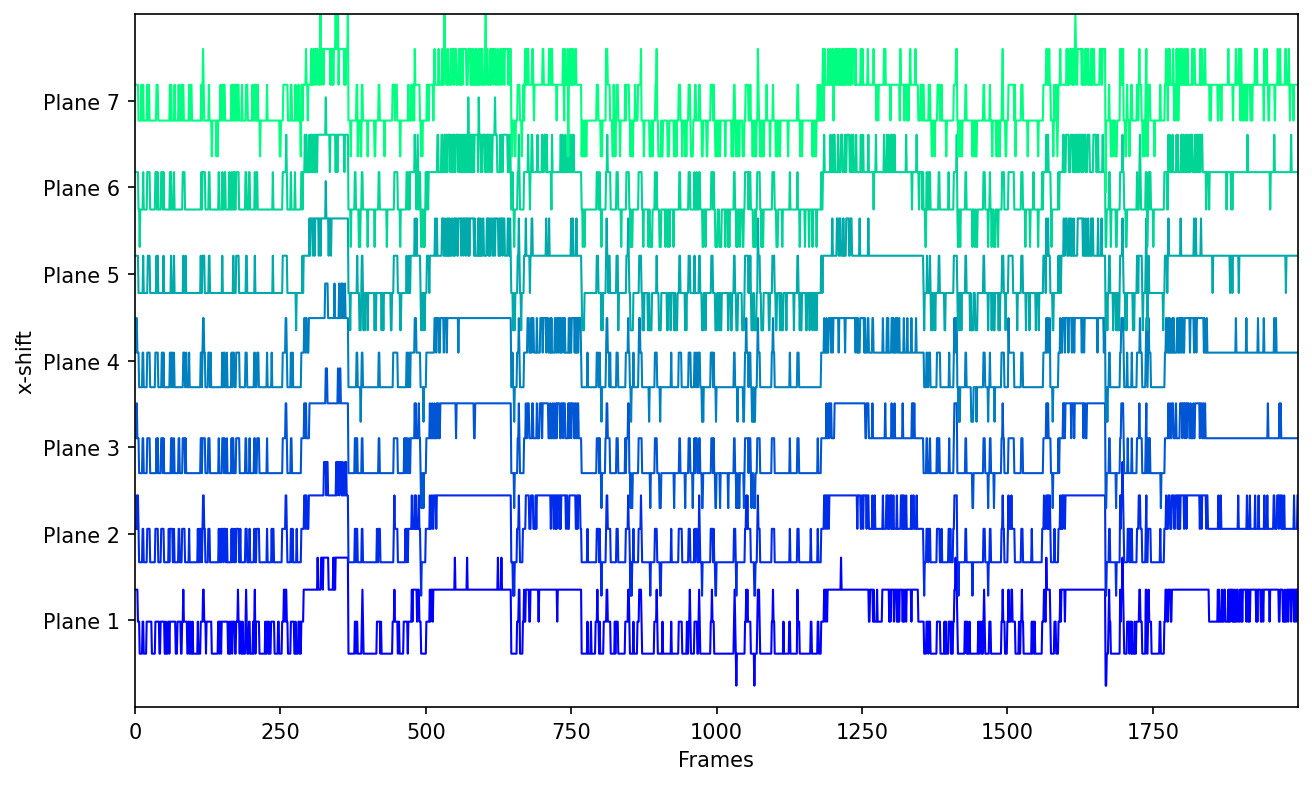

In [96]:
f,ax = plt.subplots(figsize=(10,6), dpi=150)
plot.multiple_timeseries(n.arange(xshifts.shape[1]), xshifts, colors=[cmap(i) for i in range(nz)],
                         labels=[f'Plane {idx+1:01d}' for idx in range(nz)],ax=ax)
ax.set_ylabel("x-shift")
ax.set_xlabel("Frames")

In [68]:
xshifts = []
yshifts = []
for op in all_ops:
    xshifts.append(op['xoff'])
    yshifts.append(op['yoff'])
xshifts = n.array(xshifts)
yshifts = n.array(yshifts)

metrics_dir ='/mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/registered_fused_data'
metric_files = []
for file in os.listdir(metrics_dir):
    if 'metrics' in file:
        metric_files.append(file)
metric_files = n.sort(metric_files)
all_metrics = {}
for file in metric_files:
    metric = n.load(os.path.join(metrics_dir,file), allow_pickle=True).item()
    for k in metric.keys():
        if k not in all_metrics:
            all_metrics[k] = []
        all_metrics[k].append(metric[k])
        
for k in all_metrics.keys():
    all_metrics[k] = n.stack(all_metrics[k])
    # all_metrics.append(metric)

Text(0.5, 1.0, 'Corr. Coef. of x-shifts')

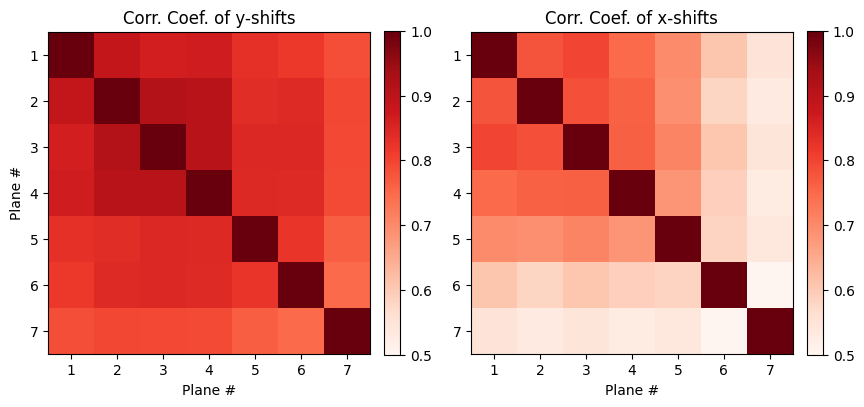

In [199]:
xcormat = n.corrcoef(xshifts)#, xshifts)
ycormat = n.corrcoef(yshifts)#, yshifts)

f,axs = plt.subplots(nrows = 1, ncols = 2, figsize=(10,5))
ax = axs[0]
im = ax.imshow(xcormat,cmap='Reds', vmin=0.5, vmax=1)
# plt.colorbar()
plt.colorbar(im,fraction=0.046, pad=0.04)
ax.set_yticks(n.arange(nz), n.arange(nz)+1)
ax.set_xticks(n.arange(nz), n.arange(nz)+1)
ax.set_xlabel("Plane #")
ax.set_ylabel("Plane #")
ax.set_title("Corr. Coef. of y-shifts")

ax = axs[1]
im = ax.imshow(ycormat, cmap='Reds', vmin=0.5, vmax=1)
plt.colorbar(im,fraction=0.046, pad=0.04)
ax.set_yticks(n.arange(nz), n.arange(nz)+1)
ax.set_xticks(n.arange(nz), n.arange(nz)+1)
ax.set_xlabel("Plane #")
ax.set_title("Corr. Coef. of x-shifts")

In [200]:
xshift_zmean = xshifts - xshifts.mean(axis=1, keepdims=True)
yshift_zmean = yshifts - yshifts.mean(axis=1, keepdims=True)

xdiff_all =  (xshift_zmean[:,n.newaxis] - xshift_zmean[n.newaxis])
xerr = (n.abs(xdiff_all)**2).mean(axis=-1) 
ydiff_all =  (yshift_zmean[:,n.newaxis] - yshift_zmean[n.newaxis])
yerr = (n.abs(ydiff_all)**2).mean(axis=-1) 


xydiff_all = n.sqrt(xdiff_all**2 + ydiff_all**2)
xydiff = xydiff_all.mean(axis=-1)
xyerr = 0.5 * (yerr + xerr)

nz = xshift_zmean.shape[0]

# difference between plane x and the mean of all planes other than x at each time
devs = n.abs(n.array([xshift_zmean[idx] -  xshift_zmean[n.where(n.arange(xshift_zmean.shape[0]) != idx)[0]].mean(axis=0) \
                                  for idx in range(xshift_zmean.shape[0])]))


frac_deviant_frames = 100*(devs >= 1.0).mean(axis=-1)

Text(0.5, 1.0, 'Mean squared diff of x-shifts')

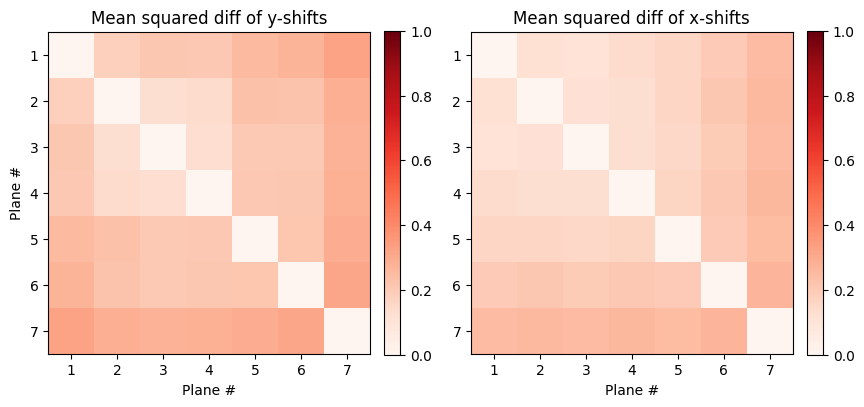

In [201]:
xcormat = n.corrcoef(xshifts)#, xshifts)
ycormat = n.corrcoef(yshifts)#, yshifts)

f,axs = plt.subplots(nrows = 1, ncols = 2, figsize=(10,5))
ax = axs[0]
im = ax.imshow(xerr,cmap='Reds', vmin=0.0, vmax=1)
# plt.colorbar()
plt.colorbar(im,fraction=0.046, pad=0.04)
ax.set_xlabel("Plane #")
ax.set_ylabel("Plane #")
ax.set_yticks(n.arange(nz), n.arange(nz)+1)
ax.set_xticks(n.arange(nz), n.arange(nz)+1)
ax.set_title("Mean squared diff of y-shifts")

ax = axs[1]
im = ax.imshow(yerr, cmap='Reds', vmin=0.0, vmax=1)
plt.colorbar(im,fraction=0.046, pad=0.04)
ax.set_yticks(n.arange(nz), n.arange(nz)+1)
ax.set_xticks(n.arange(nz), n.arange(nz)+1)
ax.set_xlabel("Plane #")
ax.set_title("Mean squared diff of x-shifts")

In [202]:
noise_levels = all_metrics['noise_levels'].mean(axis=(0,2))
signal_to_background_ratio = all_metrics['signal_to_background_ratio'].mean(axis=0)
plane_stds = all_metrics['volume_std'].mean(axis=0)
signal_ranges = all_metrics['signal_range'].mean(axis=0)

sbr_mat = (signal_to_background_ratio[n.newaxis] + signal_to_background_ratio[:,n.newaxis])/2
shn_mat = (noise_levels[n.newaxis] + noise_levels[:,n.newaxis])/2
std_mat = (plane_stds[n.newaxis] + plane_stds[:,n.newaxis])/2
rng_mat = (signal_ranges[n.newaxis] + signal_ranges[:,n.newaxis])/2


In [210]:
def scatter_with_fit(x,y,ax, flatten_lower_tri=True, sc_args = None, ln_args = None):
    if flatten_lower_tri:
        if len(x.shape) > 1: x = plot.flatten_lower_tri(x)
        if len(y.shape) > 1: y = plot.flatten_lower_tri(y)
    if sc_args is None:
        sc_args = {}
    if ln_args is None:
        ln_args = {}
    lreg = stats.linregress(x,y)
    ax.scatter(x,y, **sc_args)
    xrng = n.array([n.min(x), n.max(x)])
    ax.plot(xrng, lreg.slope * xrng + lreg.intercept, **ln_args, label=f'R={lreg.rvalue:5.2f}\n p={n.format_float_scientific(lreg.pvalue,precision=2)}')

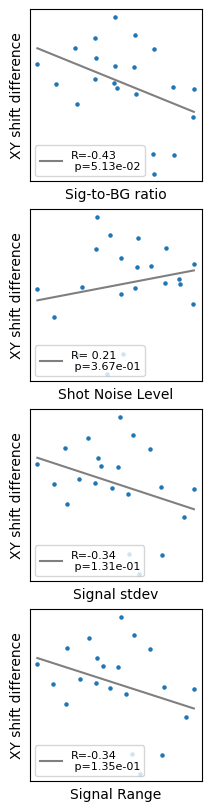

In [211]:
ylabel = 'XY shift difference'
f,axs = plt.subplots(4,1, layout='constrained', figsize=(2,8))
axs = [axs]
ax = axs[0][0]
# ax.scatter(plot.flatten_lower_tri(sbr_mat), plot.flatten_lower_tri(0.5*(yerr + xerr)), s = 5)
scatter_with_fit(sbr_mat, xydiff, ax, sc_args = {'s' : 5}, ln_args = {'color':'k', 'alpha' : 0.5})
ax.set_yticks([])
ax.set_ylabel(ylabel)
ax.set_xticks([])
ax.legend(fontsize=8, loc='lower left')
ax.set_xlabel('Sig-to-BG ratio')
ax = axs[0][1]
scatter_with_fit(shn_mat, xydiff, ax, sc_args = {'s' : 5}, ln_args = {'color':'k', 'alpha' : 0.5})
ax.set_yticks([])
ax.set_ylabel(ylabel)
ax.set_xticks([])
ax.legend(fontsize=8, loc='lower left')
ax.set_xlabel('Shot Noise Level')
ax = axs[0][2]
scatter_with_fit(std_mat, xydiff, ax, sc_args = {'s' : 5}, ln_args = {'color':'k', 'alpha' : 0.5})
ax.set_yticks([])
ax.set_ylabel(ylabel)
ax.set_xticks([])
ax.legend(fontsize=8, loc='lower left')
ax.set_xlabel('Signal stdev')
ax = axs[0][3]
scatter_with_fit(rng_mat, xydiff, ax, sc_args = {'s' : 5}, ln_args = {'color':'k', 'alpha' : 0.5})
ax.set_yticks([])
ax.set_ylabel(ylabel)
ax.set_xticks([])
ax.set_xlabel('Signal Range')
ax.legend(fontsize=8, loc='lower left')

In [ ]:
frac_deviant_frames

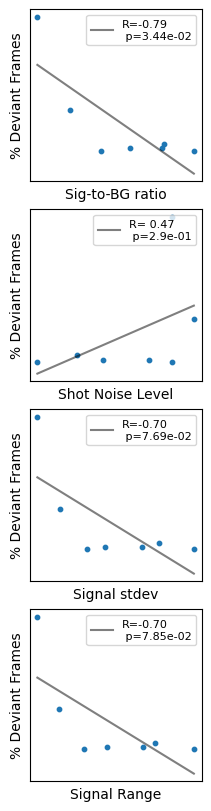

In [216]:
ylabel = '% Deviant Frames'
s = 10
loc = 'upper right'
f,axs = plt.subplots(4,1, layout='constrained', figsize=(2,8))
axs = [axs]
ax = axs[0][0]
# ax.scatter(plot.flatten_lower_tri(sbr_mat), plot.flatten_lower_tri(0.5*(yerr + xerr)), s = 5)
scatter_with_fit(signal_to_background_ratio, frac_deviant_frames, ax, sc_args = {'s' : s}, ln_args = {'color':'k', 'alpha' : 0.5})
ax.set_yticks([])
ax.set_ylabel(ylabel)
ax.set_xticks([])
ax.legend(fontsize=8, loc=loc)
ax.set_xlabel('Sig-to-BG ratio')
ax = axs[0][1]
scatter_with_fit(noise_levels, frac_deviant_frames, ax, sc_args = {'s' : s}, ln_args = {'color':'k', 'alpha' : 0.5})
ax.set_yticks([])
ax.set_ylabel(ylabel)
ax.set_xticks([])
ax.legend(fontsize=8, loc=loc)
ax.set_xlabel('Shot Noise Level')
ax = axs[0][2]
scatter_with_fit(plane_stds, frac_deviant_frames, ax, sc_args = {'s' : s}, ln_args = {'color':'k', 'alpha' : 0.5})
ax.set_yticks([])
ax.set_ylabel(ylabel)
ax.set_xticks([])
ax.legend(fontsize=8, loc=loc)
ax.set_xlabel('Signal stdev')
ax = axs[0][3]
scatter_with_fit(signal_ranges, frac_deviant_frames, ax, sc_args = {'s' : s}, ln_args = {'color':'k', 'alpha' : 0.5})
ax.set_yticks([])
ax.set_ylabel(ylabel)
ax.set_xticks([])
ax.set_xlabel('Signal Range')
ax.legend(fontsize=8, loc=loc)

Text(0, 0.5, '% of frames w/ deviation')

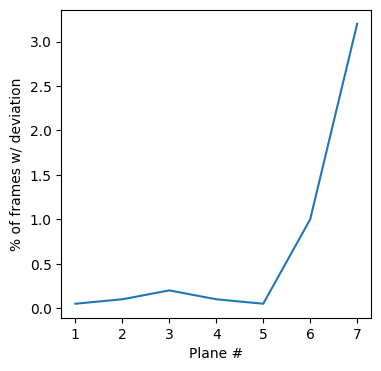

In [205]:
f,ax = plt.subplots(figsize=(4,4))
ax.plot(n.arange(1,nz+1), 100*(devs >= 1.0).mean(axis=-1))
ax.set_xlabel("Plane #")
ax.set_ylabel("% of frames w/ deviation")

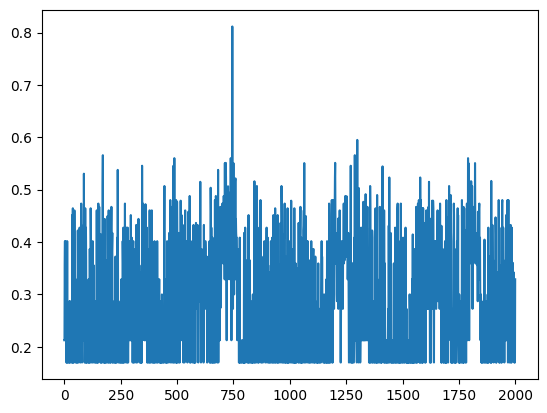

In [207]:
plt.plot(devs.mean(axis=0))

In [ ]:
n.argsort(

In [220]:
worst_frames = (-devs.mean(axis=0)).argsort()

In [222]:
print(worst_frames[:100])

[ 745 1299  171 1288 1790  738  488 1201  716 1821 1064  750  712 1793
  345 1270  484 1411  237  682   87 1791 1578  717 1441 1200  759 1893
 1804 1797  758 1290  843  603 1617 1808  170  963 1706  444 1356  854
  726  649 1306  732 1336 1387 1713  556 1246  672  707 1252  870 1694
  673 1969 1572 1926 1965 1942 1192 1186 1763 1581  470  668  496 1006
  516 1199 1635 1631 1326  500 1941 1328 1840 1666 1785 1492  701 1568
 1239 1800 1727   75 1478  349  964  977  269 1174  151  360 1615  692
  740 1344]
